In [776]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
gpu_implementation_analysis_path = '/home/mt/repos/research.mtne/gpu_implementation/analysis'
if gpu_implementation_analysis_path not in sys.path:
    sys.path.append(gpu_implementation_analysis_path)
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import utils
from metrics import *

# from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [777]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT' },
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'ST'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'}    
}

In [778]:
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)
    exp['rewards'] = utils.get_rewards(exp)

/home/mt/repos/research.mtne/gpu_implementation/logs/ST-zaxxon-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_zaxxon_using_riverraid_model


/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/home/mt/repos/research.mtne/gpu_implementation/logs/MT-zaxxon-riverraid-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_riverraid_using_zaxxon_model
/home/mt/repos/research.mtne/gpu_implementation/logs/ST-riverraid-5000


In [779]:
iterations = 200

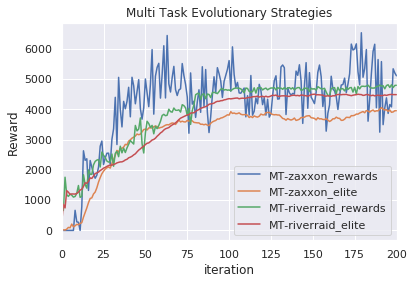

In [780]:
# 1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
p = experiments['MT']['rewards'].plot()
p.set_title('Multi Task Evolutionary Strategies')
p.set_ylabel('Reward')
p.set(xlim=(0, iterations))
p.get_figure().savefig("plot1.eps")

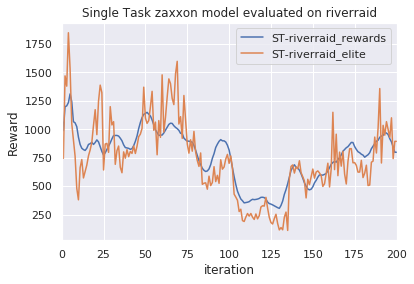

In [781]:
# 2) STES rewards (both offspring and elite) [zaxxon evaluated on riverraid]
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
p = experiments['ST-riverraid-zaxxon']['rewards'].plot()
p.set_title('Single Task zaxxon model evaluated on riverraid')
p.set_ylabel('Reward')
p.set(xlim=(0, iterations))
p.get_figure().savefig("plot2_st_riverraid_zaxxon.eps")

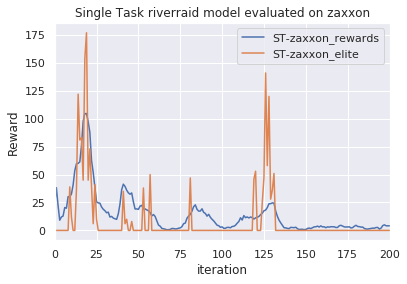

In [782]:
# 3) Same as 2, but STES [riverraid evaluated on zaxxon]
p = experiments['ST-zaxxon-riverraid']['rewards'].plot()
p.set_title('Single Task riverraid model evaluated on zaxxon')
p.set_ylabel('Reward')
p.set(xlim=(0, iterations))
p.get_figure().savefig("plot3_st_zaxxon_riverraid.eps")

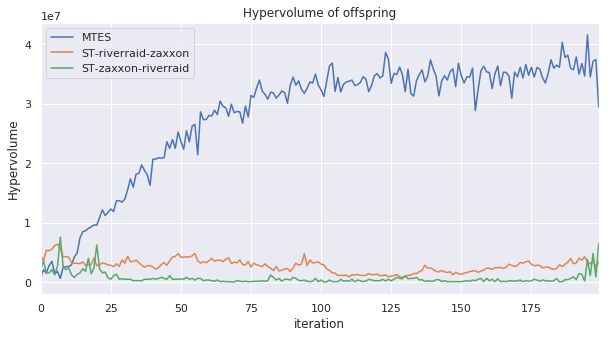

In [783]:
# 4) hypervolume (offspring only)
# x axis: iterations (0 to 200)
# y axis: hypervolume
# lines: (a) MTES; (b) STES [zaxxon evaluated on riverraid]; (c) STES [riverraid evaluated on zaxxon].
hv_df = pd.DataFrame.from_dict({
    'MTES': utils.get_hypervolume_data(experiments['MT'], iterations)['hv'],
    'ST-riverraid-zaxxon': utils.get_hypervolume_data(experiments['ST-riverraid-zaxxon'], iterations)['hv'],
    'ST-zaxxon-riverraid': utils.get_hypervolume_data(experiments['ST-zaxxon-riverraid'], iterations)['hv']
})
sns.set(rc={'figure.figsize': (10, 5)})
hv_df['iteration'] = range(0, iterations)
hv_df.set_index('iteration')
del hv_df['iteration']
p = hv_df.plot()
p.set_title('Hypervolume of offspring')
p.set_ylabel('Hypervolume')
p.get_figure().savefig("plot4_hypervolume.eps")

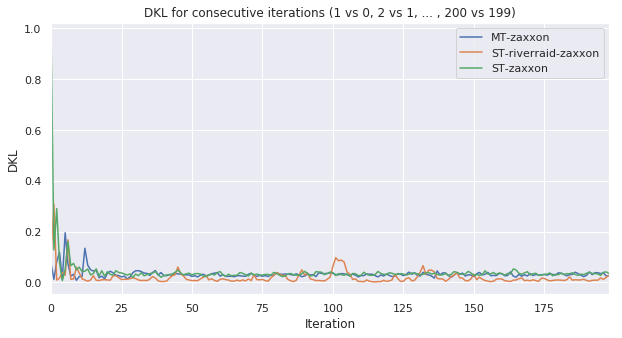

In [784]:
# 5) DKL (offspring only) – 2 plots: one for task 0, one for task 1
# x axis: iterations (0 to 200)
# y axis: DKL for consecutive iterations (1 vs 0, 2 vs 1, 3 vs 2, ... , 200 vs 199)
# lines: (a) MTES; (b) STES [zaxxon evaluated on riverraid]; (c) STES [riverraid evaluated on zaxxon].

bin_size = 100
epsilon = 0.0001
dkl0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon) for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon) for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon) for i in range(1, iterations)]
})
p = dkl0.plot()
p.set_title("DKL for consecutive iterations (1 vs 0, 2 vs 1, ... , 200 vs 199)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")
p.get_figure().savefig("plot5_dkl.eps")

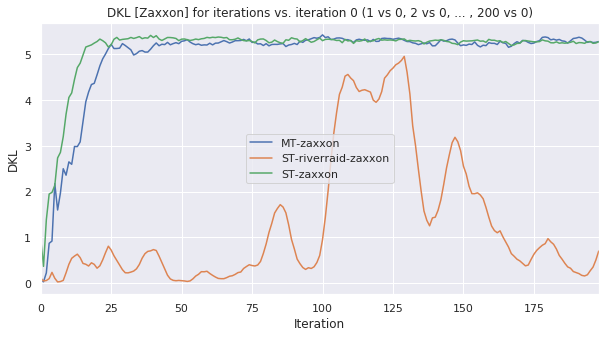

In [785]:
# 6) same as 5), but y axis is “DKL for iterations (1 vs 0, 2 vs 0, 3 vs 0, ... , 200 vs 0)” (note: also in this case we need 2 plots: one for task 0, one for tasak 1)
dkl_from0_0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_0.plot()
p.set_title("DKL [Zaxxon] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")
p.get_figure().savefig("plot6_dkl_zaxxon.eps")

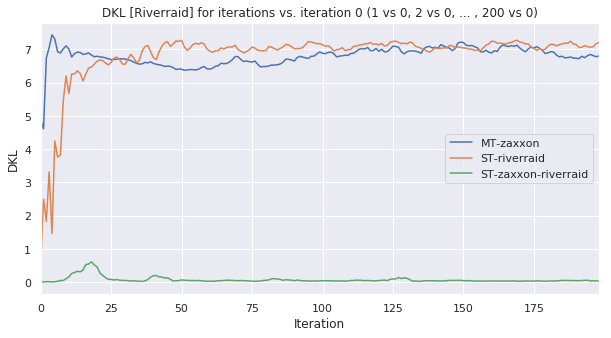

In [786]:
dkl_from0_1 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-riverraid': [utils.compute_dkl(experiments['ST-riverraid'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-zaxxon-riverraid': [utils.compute_dkl(experiments['ST-zaxxon-riverraid'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_1.plot()
p.set_title("DKL [Riverraid] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")
p.get_figure().savefig("plot6_dkl_riverraid.eps")

In [787]:
### TOO NOISY
# # 7) - same as 5) but elite only
# dkl_elite_0 = pd.DataFrame.from_dict({
#     'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
#     'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
#     'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)]
# })
# p = dkl_elite_0.plot()
# p.set_title("DKL elite [Zaxxon] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
# p.set_xlabel("Iteration")
# p.set_ylabel("DKL")

In [788]:
### TOO NOISY
# dkl_elite_1 = pd.DataFrame.from_dict({
#     'MT-riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
#     'ST-riverraid': [utils.compute_dkl(experiments['ST-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
#     'ST-zaxxon-riverraid': [utils.compute_dkl(experiments['ST-zaxxon-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)]
# })
# p = dkl_elite_1.plot()
# p.set_title("DKL elite [Riverraid] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
# p.set_xlabel("Iteration")
# p.set_ylabel("DKL")

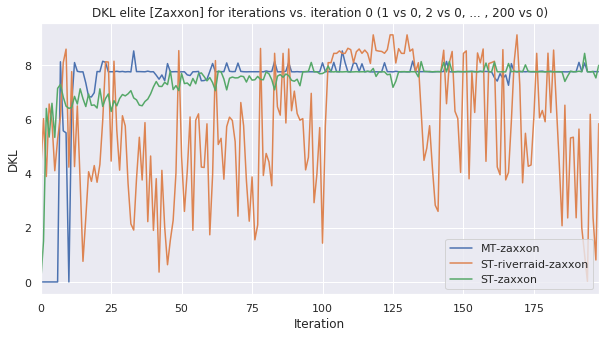

In [789]:
# 8) same as 6) but elite
dkl_from0_elite_0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_elite_0.plot()
p.set_title("DKL elite [Zaxxon] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")
p.get_figure().savefig("plot8_dkl_zaxxon.eps")

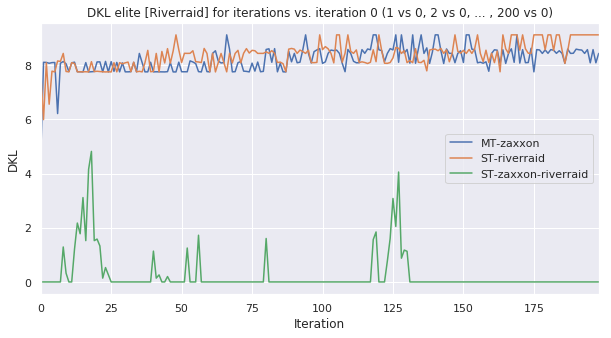

In [790]:
dkl_from0_elite_1 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-riverraid': [utils.compute_dkl(experiments['ST-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-zaxxon-riverraid': [utils.compute_dkl(experiments['ST-zaxxon-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_elite_1.plot()
p.set_title("DKL elite [Riverraid] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")
p.get_figure().savefig("plot8_dkl_riverraid.eps")

In [791]:
### SCATTERPLOTS

In [792]:
iterlist = [0, 25, 50, 75, 100, 125, 150, 175, 199]

def get_paretos(exp, iterations, rewards=None, iterlist=iterlist):
    game_rewards = utils.get_game_rewards(exp, iterations) if rewards is None else rewards
    paretos = []
    for iteration in range(0, iterations):
        game0_rewards = game_rewards[game_rewards.iteration == iteration]['game0_rewards']
        game1_rewards = game_rewards[game_rewards.iteration == iteration]['game1_rewards']
        pareto_x, pareto_y = utils.compute_pareto(game0_rewards, game1_rewards)
        paretos.append(pd.DataFrame({'iteration': [iteration] * len(pareto_x), 'game0_rewards': pareto_x, 'game1_rewards': pareto_y}))
    paretos_df = pd.concat(paretos)
    only_paretos = paretos_df[paretos_df['iteration'].isin(iterlist)]
    only_paretos['newidx'] = list(range(0, len(only_paretos)))
    only_paretos.set_index('newidx')
    del only_paretos['newidx']
    return only_paretos
def pareto_and_points_for_iteration(game_rewards, paretos, iteration):
    game_rewards_iteration = game_rewards[game_rewards.iteration == iteration]
    paretos_iteration = paretos[paretos.iteration == iteration]
    return game_rewards_iteration, paretos_iteration
def get_scatter_reward_and_pareto(game_rewards, paretos, iteration, max_x_lim=8000, max_y_lim=8000):
    game_rewards, paretos = pareto_and_points_for_iteration(game_rewards, paretos, iteration)
    p = sns.scatterplot(x='game0_rewards', y='game1_rewards', color='black', alpha=0.1, data=game_rewards)
    p = sns.scatterplot(x='game0_rewards', y='game1_rewards', color='red', data=paretos)
    p = sns.lineplot(x='game0_rewards', y='game1_rewards', color='red', data=paretos)
    p.set_title("Iteration {}".format(iteration))
    p.set_xlim([0, max_x_lim])
    p.set_ylim([0, max_y_lim])
    return p
def get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist):
    iterlist_keys = list(range(1, len(iterlist) + 1))
    iterdict = dict(zip(iterlist_keys, iterlist))
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        get_scatter_reward_and_pareto(all_game_rewards, only_paretos, iterdict[i])
    return plt

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


<module 'matplotlib.pyplot' from '/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

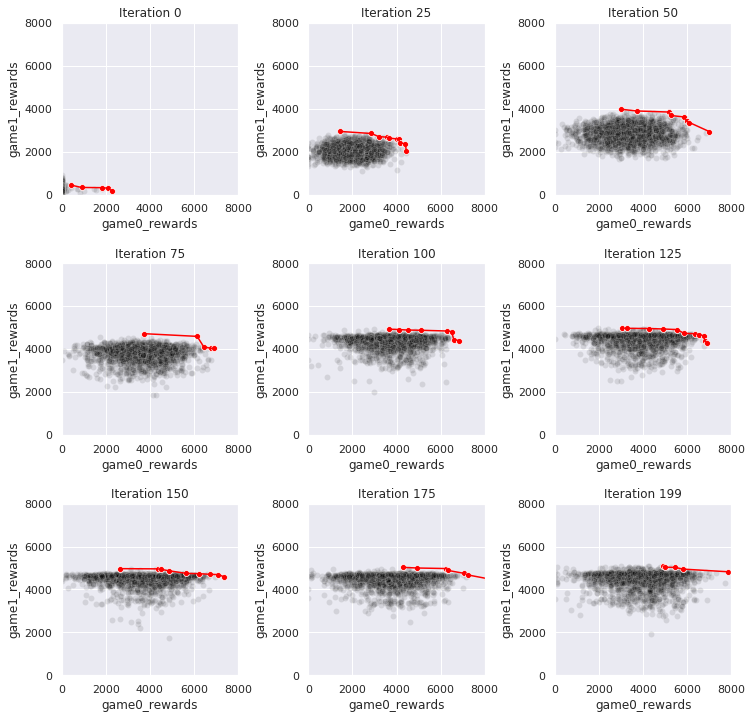

In [793]:
# Scatterplots: (one plot for iterations: [0, 25, 50, 75, 100, 125, 150, 175, 200] ) → 9 plots
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: (a) feasible points only (reward>0); (b) pareto front points, in red + red line connecting those points.
all_game_rewards = utils.get_game_rewards(experiments['MT'], iterations)
only_paretos = get_paretos(exp, iterations, all_game_rewards)
get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist)

In [794]:
# 2) same as (1), but STES [zaxxon evaluated on riverraid] instead of MTES
all_game_rewards = utils.get_game_rewards(experiments['ST-riverraid-zaxxon'], iterations)
only_paretos = get_paretos(exp, iterations, all_game_rewards)
get_game0vs1_and_pareto_grid(iterlist)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_riverraid_using_zaxxon_model/0000-game1_rewards.pkl'

In [ ]:
# Scatterplots: (one plot for iterations: [0, 25, 50, 75, 100, 125, 150, 175, 200] ) → 9 plots
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: (a) feasible points only (reward>0); (b) pareto front points, in red + red line connecting those points.

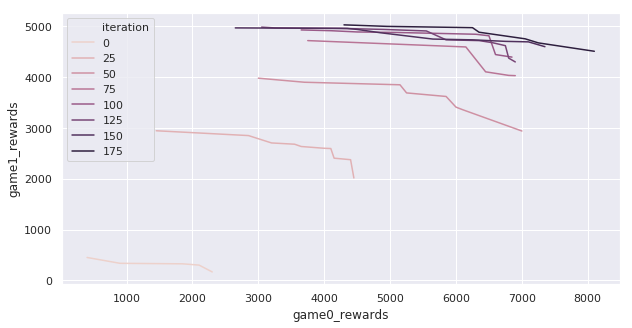

In [653]:
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: pareto front points + line connecting those points. One line for each iterations in [0, 25, 50, 75, 100, 125, 150, 175, 200]

p = sns.lineplot(x='game0_rewards', y='game1_rewards', hue='iteration', legend='full', data=only_paretos)
p.set_title()

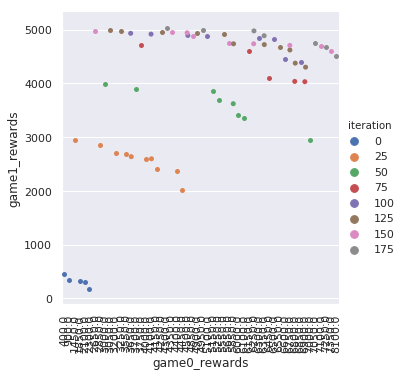

In [565]:
sns.set(rc={'figure.figsize': (20, 20)})
p = sns.catplot(x='game0_rewards', y='game1_rewards', hue='iteration', data=only_paretos)
p.set_xticklabels(rotation=90)

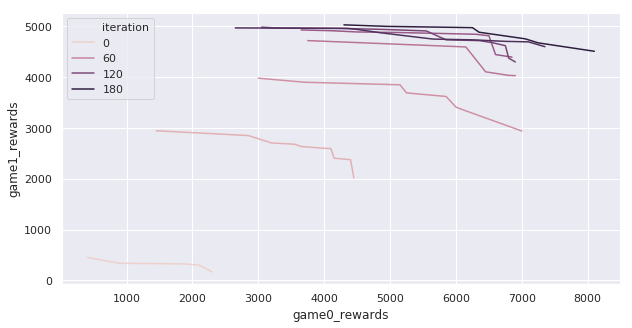

In [574]:
sns.set(rc={'figure.figsize': (10, 5)})
p = sns.lineplot(x='game0_rewards', y='game1_rewards', hue='iteration', data=only_paretos)

In [467]:
pdata = paretos_df[paretos_df['iteration'].isin([0, 25, 50])]

In [468]:
pdata

,iteration,x,y
0,0,"[400.0, 900.0, 1850.0, 2100.0, 2300.0]","[450.0, 335.0, 325.0, 300.0, 165.0]"
25,25,"[1450.0, 2850.0, 3200.0, 3550.0, 3650.0, 4000....","[2945.0, 2850.0, 2705.0, 2680.0, 2635.0, 2600...."
50,50,"[3000.0, 3700.0, 5150.0, 5250.0, 5850.0, 6000....","[3980.0, 3900.0, 3850.0, 3690.0, 3620.0, 3410...."


In [439]:
for iteration in [0, 25, 50, 75, 100]:
    pareto_df = paretos_df[paretos_df.iteration == iteration]
    print(pareto_df.columns)
    break
    pareto_x = pareto_df['game0_rewards']
    pareto_y = paret_df['game1_rewards']

Index(['pareto', 'iteration'], dtype='object')


In [437]:
p

199    ([4900.0, 5000.0, 5450.0, 5800.0, 7850.0], [50...
Name: pareto, dtype: object

In [416]:
which_pareto = 199

In [417]:
paretos_df = pd.DataFrame({'reward_g0': paretos[which_pareto][0], 'reward_g1': paretos[which_pareto][1]})

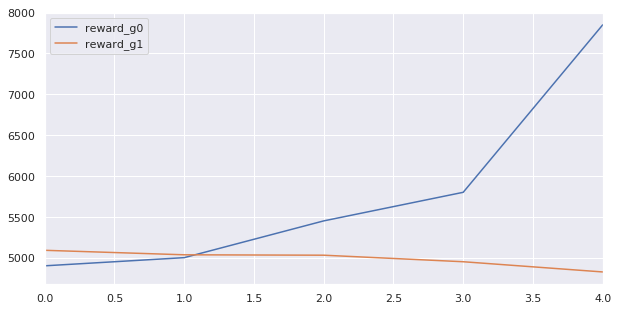

In [418]:
paretos_df.plot()